In [ ]:
!pip install geopandas
!pip install geojson
!pip install rasterio
!pip install rasterstats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 14.6 MB/s 
     |████████████████████████████████| 6.3 MB 58.3 MB/s 
     |████████████████████████████████| 16.7 MB 270 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 623 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 130 kB 15.7 MB/s 


In [ ]:
from os import path as op
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import csv

import pickle
import rasterio
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import itertools
from scipy import ndimage
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
import torch.nn.functional as F 

from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 

In [ ]:
 %load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/data')

In [ ]:
import sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Space_Intelligence/Project_Scotland/Scotland_Segmentation_Sparse_Labels/src')

In [ ]:
import CNN_Train_Validate 

In [ ]:
X = np.load('X.npy')

In [ ]:
X[0].shape

(13, 256, 256)

In [ ]:
X[0][0]

array([[0.1233 , 0.11295, 0.12025, ..., 0.11025, 0.10965, 0.11195],
       [0.12655, 0.1224 , 0.1206 , ..., 0.11355, 0.1133 , 0.1103 ],
       [0.1247 , 0.1214 , 0.1227 , ..., 0.11945, 0.1137 , 0.10495],
       ...,
       [0.1069 , 0.10555, 0.1065 , ..., 0.10055, 0.09465, 0.0905 ],
       [0.1085 , 0.10405, 0.10155, ..., 0.10955, 0.1055 , 0.0993 ],
       [0.1068 , 0.0977 , 0.101  , ..., 0.1029 , 0.1012 , 0.10025]],
      dtype=float32)

In [ ]:
y = np.load('y.npy')

In [ ]:
y[0].shape

(1, 256, 256)

In [ ]:
classes = ['Agriculture', 'Bares_and_Built', 'Bogs', 'Forest', 'Grassland','Shrub/Heathland','Water']
labels=[0,1,2,3,4,5,6]

In [ ]:
train_data,test_data = CNN_Train_Validate.create_train_test_split(X,y,test_size=0.3,random_state=42,gpu=True)


In [ ]:
# create a test model
model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=32).cuda()

In [ ]:
def mask_trainings_and_predictions_equal_polygons(x_train,y_train,model):

 '''
   Input: batch from our training dataset and our model.
   Output: modified y_train and modified predictions.
   
   Description: We work with sparse labels so most of the pixels in the elements of y_batch
                will be nodata (less than 0 ). We don't want our loss to take them into account,
                so we need to create a mask which restricts the domain of the loss function
                only on the non-negative pixel values of the elements from y_batch. In this fun-
                ction we also consider each polygon to be equally important, no matter how small
                it is.

  '''
# record the batch size
 batch_size = y_train.shape[0]

  # we find the predictions
 y_pred  = model(x_train)

 # copy(clone) y_train
 y_train_copy = y_train.clone()

# we create the desired mask and apply it to y_train
 mask_train = (y_train >= 0)
 y_train_masked = y_train[mask_train]

 # we reshape it by removing a band ( band 1 )
 y_train_copy = y_train_copy.reshape(batch_size,256,256)

 # we merge the labels from each batch to one long image
 y_train_copy = y_train_copy.reshape(256*batch_size,256).T

 # -999 -> 0, -1->0, 0->500. 
 mask_999 = (y_train_copy==-999)
 mask_0 = (y_train_copy==0)
 mask_1 = (y_train_copy==-1)

 y_train_copy[mask_999]=0
 y_train_copy[mask_1]=0
 y_train_copy[mask_0]=500

 # we will need this structure for the following function
 s = ndimage.generate_binary_structure(2,2)

 # this is our polygons id mask
 
 polygons_id_mask = ndimage.label(y_train_copy.cpu(),structure=s)[0]
 polygons_id_mask = torch.LongTensor(polygons_id_mask.T)
 polygons_id_mask = polygons_id_mask.view(batch_size,1,256,256)

 # we use the mask_train to take only the non nan valus
 polygons_id_mask_masked = polygons_id_mask[mask_train]

 # we reshape our mask ( remove 1 dimension )
 mask_train = mask_train.reshape([len(x_train),256,256])

# this is our masked y_pred
 y_pred = torch.cat([y_pred[:,0,:,:][mask_train],  y_pred[:,1,:,:][mask_train],y_pred[:,2,:,:][mask_train],y_pred[:,3,:,:][mask_train],
           y_pred[:,4,:,:][mask_train],y_pred[:,5,:,:][mask_train], y_pred[:,6,:,:][mask_train]],dim=0)
  
                      
  # we fix y_pred to the appropriate shape
 y_pred = torch.transpose(y_pred.view(7,-1),0,1)

 # we take the indexes of the sorted polygons_id_mask_masked
 sorted_indexes_polygons_id_mask_masked = polygons_id_mask_masked.argsort()

 # we sort y_train, y_pred, and polygons_id_mask_masked based on the above indexes
 y_train_masked_sorted = y_train_masked[sorted_indexes_polygons_id_mask_masked]
 sorted_polygons_id_mask_masked = polygons_id_mask_masked[sorted_indexes_polygons_id_mask_masked]
 y_pred_masked_sorted = y_pred[sorted_indexes_polygons_id_mask_masked]


 # now we divide our y_train and y_pred into subsets for every polygon
 y_train_masked_split_by_polygons = np.split(y_train_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])
 y_pred_masked_split_by_polygons = np.split(y_pred_masked_sorted, np.unique(sorted_polygons_id_mask_masked, return_index=True)[1][1:])

 return y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons

In [ ]:
def calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons):

    '''
    This function takes two input arguments: y_train_masked_split_by_polygons and
    y_pred_masked_split_by_polygons, which denote our y_train labels per pixel but
    grouped also per polygon. That is how we give equal importance to each polygon
    when training.
    Output cross_entropy_loss as average of the losses for the number of polygons
    '''
    number_of_polygons = len(y_pred_masked_split_by_polygons)
    acc_loss = 0 # the accumulated loss based on the polygons
    criterion = nn.CrossEntropyLoss()
    for y_t,y_p in zip(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons):
        
        acc_loss+=criterion(y_p,y_t)
        
    return acc_loss/number_of_polygons

In [ ]:
def train_validate_model(train_data,test_data,labels,classes,input_model = False,init_features=32,batch_size=16,epochs=20,init_lr=0.001,verbose=True,gpu=True):
    
    '''
    Function that trains our neural network
    input: train and test data, labels=[0,1,2,3,...],classes=['Agriculture',..] 
           init_features, batch_size, number of epochs,
           and gpu = True/False - whether we use gpu or not
           init_lr - initial learning rate

    output: our trained model, all true classes from the whole test set, and all
            predicted classes from the test set
    '''
    np.random.seed(3407)
    torch.manual_seed(3407)
    torch.use_deterministic_algorithms(True)
    
    # trackers for printing
    train_losses=[]
    val_losses=[]
    Epochs = list(torch.arange(epochs))

    # we check for input model
    if input_model==False:  
      
      # instatiate our model
      if gpu == True:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features).cuda()
      else:
          model = CNN_Train_Validate.UNet(in_channels=13,out_channels=7,init_features=init_features)
    
    else:
      model = input_model

    # creating our train and test loaders
    train_loader = DataLoader(train_data,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_data,batch_size=45,shuffle=False)

    # setting our loss function and our optimizer
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(),lr = init_lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,20)

    for i in range(epochs):
        i+=1
        
        ########## TRAINING ########
        for batch,(x_train_batch,y_train_batch) in enumerate(train_loader):
            batch+=1

            # apply mask on our y_train_batch and y_pred_batch 
            y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons = mask_trainings_and_predictions_equal_polygons(x_train_batch,y_train_batch,model)
        
            # calculate the loss for the current batch
            train_loss=calculate_loss(y_train_masked_split_by_polygons,y_pred_masked_split_by_polygons)
            
            optimizer.zero_grad() # optimizing
            train_loss.backward()       # back propagation
            optimizer.step()      # step update
        
        # update the scheduler
        scheduler.step()

        # update the train losses
        train_losses.append(train_loss)

        if verbose == True:
            print(f"Epoch:{i}, train_loss:{train_loss}, {optimizer.param_groups[0]['lr']}")

        ######## VALIDATION ######

        # if we are in the last epoch
        if i == epochs-1:
          
          test_predictions=[] # we will append here the predictions from 
                              # y_pred_batch from each test batch
                            
          test_true = [] # we will append here the y_test_batch from each
                         # test batch

        for batch,(x_test_batch,y_test_batch) in enumerate(test_loader):

            with torch.no_grad():
                 
                 # apply mask on our y_train_batch and y_pred_batch 
                y_test_batch,y_pred_batch = CNN_Train_Validate.mask_trainings_and_predictions(x_test_batch,y_test_batch,model)
            
            if i == epochs-1:
              # generate batch predictions from y_pred_batch
              batch_predictions = CNN_Train_Validate.nn_generate_predictions(y_pred_batch)
              test_predictions+=batch_predictions

              # append the results for 
              test_true+=list(y_test_batch.cpu().detach().numpy())
            
            # calculate the loss for the current batch
            val_loss=criterion(y_pred_batch,y_test_batch)  

        # Update the val losses
        val_losses.append(val_loss)

        # Adjust the learning rate based on the validation loss
        #scheduler.step(val_loss)
        
        if verbose == True:
            print(f"Epoch:{i}, val_loss:{val_loss}, {optimizer.param_groups[0]['lr']}")

    print(' ')
    print(f'init features: {init_features}, batch size: {batch_size}, learning rate: {init_lr}')

    ####################### PLOTTING #############################

    # plot a confusion matrix
    cm = confusion_matrix(test_true,test_predictions,labels=labels)
    CNN_Train_Validate.plot_cm(cm,classes)


    # Plot train and validation losses
    train_losses = [item.cpu().detach() for item in train_losses]
    val_losses = [item.cpu().detach() for item in val_losses]
    plt.title('TRAIN AND VALIDATION LOSSES')
    plt.plot(Epochs,train_losses,label='train_loss',color='blue')
    plt.plot(Epochs,val_losses,label='val_loss',color='red')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model,test_true,test_predictions


Epoch:1, train_loss:1.0748021602630615, 0.0009938441702975688
Epoch:1, val_loss:1.1794092655181885, 0.0009938441702975688
Epoch:2, train_loss:0.9205096364021301, 0.0009755282581475768
Epoch:2, val_loss:0.9182299971580505, 0.0009755282581475768
Epoch:3, train_loss:0.9253692626953125, 0.0009455032620941839
Epoch:3, val_loss:0.6886720657348633, 0.0009455032620941839
Epoch:4, train_loss:0.755258321762085, 0.0009045084971874737
Epoch:4, val_loss:0.6712543368339539, 0.0009045084971874737
Epoch:5, train_loss:1.2314989566802979, 0.0008535533905932737
Epoch:5, val_loss:0.6359302401542664, 0.0008535533905932737
Epoch:6, train_loss:1.5989891290664673, 0.0007938926261462366
Epoch:6, val_loss:0.7059206962585449, 0.0007938926261462366
Epoch:7, train_loss:0.3877694308757782, 0.0007269952498697733
Epoch:7, val_loss:0.6073340773582458, 0.0007269952498697733
Epoch:8, train_loss:0.9028096199035645, 0.0006545084971874737
Epoch:8, val_loss:0.6429523825645447, 0.0006545084971874737
Epoch:9, train_loss:1.017

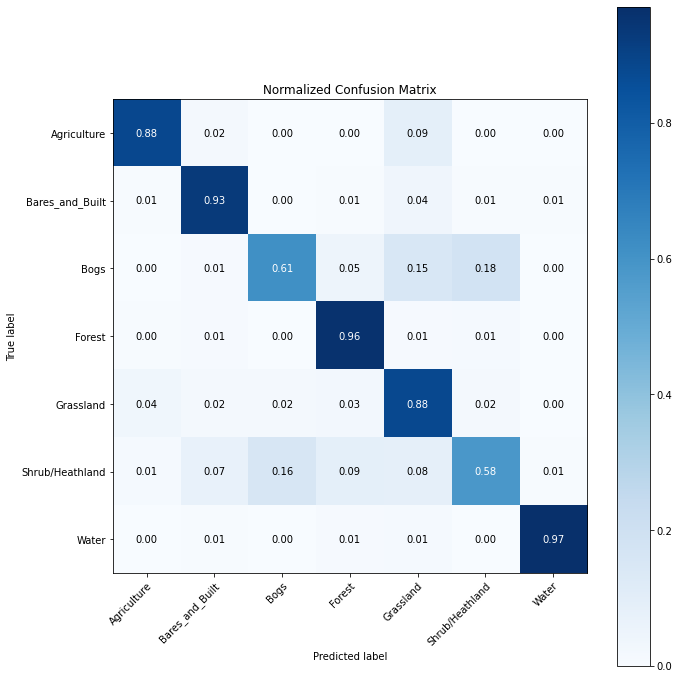

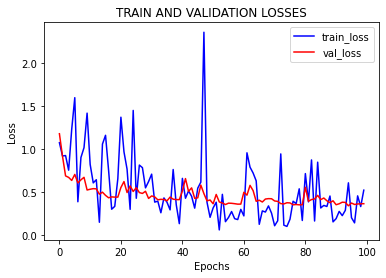

In [ ]:
# cosine annealing warm restart
model,test_true,test_predictions  = train_validate_model(train_data,test_data,labels,classes,init_features=64,epochs=100,batch_size = 4,init_lr=1e-3);

In [ ]:
CNN_Train_Validate.test_statistics(test_true,test_predictions,verbose=True);

Balanced Accuracy:0.8318777474417948
Recall:0.8882365802995518
Precision:0.892031652642216
f1 score:0.8881109556628319


In [ ]:
torch.save(model.state_dict(),'Scotland_600_ca.net')

Epoch:1, train_loss:0.18740062415599823, 9.972609476841367e-05
Epoch:1, val_loss:0.3124033212661743, 9.972609476841367e-05
Epoch:2, train_loss:0.15042491257190704, 9.890738003669029e-05
Epoch:2, val_loss:0.3041018545627594, 9.890738003669029e-05
Epoch:3, train_loss:0.1986437737941742, 9.755282581475769e-05
Epoch:3, val_loss:0.3047037720680237, 9.755282581475769e-05
Epoch:4, train_loss:0.23993253707885742, 9.567727288213005e-05
Epoch:4, val_loss:0.2999480366706848, 9.567727288213005e-05
Epoch:5, train_loss:0.7071694731712341, 9.330127018922194e-05
Epoch:5, val_loss:0.3033522963523865, 9.330127018922194e-05
Epoch:6, train_loss:0.07024960219860077, 9.045084971874738e-05
Epoch:6, val_loss:0.3002051115036011, 9.045084971874738e-05
Epoch:7, train_loss:0.12707974016666412, 8.715724127386972e-05
Epoch:7, val_loss:0.29423758387565613, 8.715724127386972e-05
Epoch:8, train_loss:0.1019490659236908, 8.345653031794292e-05
Epoch:8, val_loss:0.2953829765319824, 8.345653031794292e-05
Epoch:9, train_los

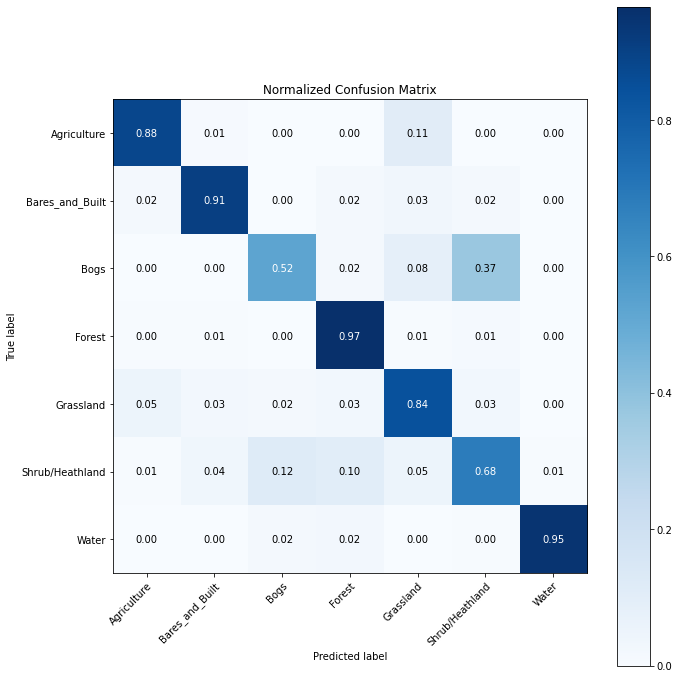

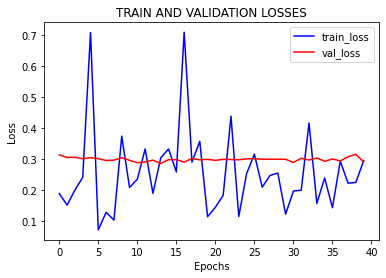

In [ ]:
# switching to manual training
model,test_true,test_predictions = train_validate_model(train_data,test_data,labels,classes,input_model = model,init_features=64,batch_size = 4,init_lr=1e-4,epochs=40);

In [ ]:
CNN_Train_Validate.test_statistics(test_true,test_predictions,verbose=True);

Balanced Accuracy:0.821698871650356
Recall:0.8853285230130097
Precision:0.8875967378677325
f1 score:0.885924784523214
